# Analysis of Flow of funds in UK Charities
- 360GrantNav data has been used
- it includes data of specific grant - date, funding and beneficiary organisation, grant amount, purpose etc
- our goal is to get some insights into the flow of funds among cities/regions/districts

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data = pd.read_csv("drive/My Drive/UK_Data/Grants/grantnav-uk-20220118164816.csv")
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,9,10,13,17,18,19,20,21,22,23,24,25,26,27,28,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,57,58,59,61,62,63,65,66,67,71,72,73,74,75,80,81,82,84,85,86,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Identifier,Title,Description,Currency,Amount Applied For,Amount Awarded,Amount Disbursed,Award Date,URL,Planned Dates:Start Date,...,Recipient Org: Org ID(s),Recipient Org: Latest Income,Recipient Org: Latest Income Date,Recipient Org: Org Type,Recipient Org: Registered Postcode,Recipient Org: Data Source,Recipient Org: Canonical Org ID,Recipient Org: Canonical Name,License (see note),"Note, this file also contains OS data © Crown copyright and database right 2016, Royal Mail data © Royal Mail copyright and Database right 2016, National Statistics data © Crown copyright and database right 2015 & 2016, see http://grantnav.threesixtygiving.org/datasets/ for more information."
0,360G-SomersetCF-A350096,Church Re-ordering,Church building conversion for community use,GBP,20000.0,20000.0,NaN,2014-11-12,NaN,2014-11-01,...,NaN,NaN,NaN,NaN,NaN,NaN,GB-REV-XN22586,South Barrow Parochial Church Council,https://creativecommons.org/licenses/by/4.0/,NaN
1,360G-SomersetCF-A377421,2014/15 Taster sessions follow-up,Horse therapy sessions for disabled children,GBP,5000.0,2620.0,NaN,2016-02-09,http://www.horseshoesandhandprints.org,2015-07-01,...,GB-CHC-1147898,0.0,2020-06-30,Registered Charity,TA20 1HD,ccew,GB-CHC-1147898,Horseshoes and Handprints,https://creativecommons.org/licenses/by/4.0/,NaN
2,360G-SomersetCF-A384802,Community Advice Pathways,Weekly advice drop-in service,GBP,1224.0,1224.0,NaN,2016-07-20,http://www.southsomcab.org.uk,2016-02-01,...,"GB-CHC-1054134, GB-COH-03173414",539413.0,2020-03-31,Registered Charity,BA20 1SH,ccew,GB-COH-03173414,Citizens Advice Bureau - South Somerset,https://creativecommons.org/licenses/by/4.0/,NaN
3,360G-SomersetCF-A388084,New kitchen/ diner,New kitchen/ diner,GBP,10000.0,2500.0,NaN,2016-02-17,http://www.swedauk.org,2016-03-01,...,"GB-CHC-1056441, GB-COH-03208772",241914.0,2020-03-31,Registered Charity,BA4 5BS,ccew,GB-COH-03208772,SWEDA,https://creativecommons.org/licenses/by/4.0/,NaN
4,360G-SomersetCF-A392582,Blackdown Support Group,Support to the elderly and the infirm in the B...,GBP,500.0,500.0,NaN,2016-05-17,http://www.blackdownsupportgroup.org.uk,2016-04-01,...,GB-CHC-1013514,52407.0,2020-03-31,Registered Charity,EX15 3SF,ccew,GB-CHC-1013514,Blackdown Support Group,https://creativecommons.org/licenses/by/4.0/,NaN


In [4]:
data.shape

(632657, 92)

Data for 632,657 grants available 

In [5]:
data.columns

Index(['Identifier', 'Title', 'Description', 'Currency', 'Amount Applied For',
       'Amount Awarded', 'Amount Disbursed', 'Award Date', 'URL',
       'Planned Dates:Start Date', 'Planned Dates:End Date',
       'Planned Dates:Duration (months)', 'Actual Dates:Start Date',
       'Actual Dates:End Date', 'Actual Dates:Duration (months)',
       'Recipient Org:Identifier', 'Recipient Org:Name',
       'Recipient Org:Charity Number', 'Recipient Org:Company Number',
       'Recipient Org:Postal Code',
       'Recipient Org:Location:0:Geographic Code Type',
       'Recipient Org:Location:0:Geographic Code',
       'Recipient Org:Location:0:Name',
       'Recipient Org:Location:1:Geographic Code Type',
       'Recipient Org:Location:1:Geographic Code',
       'Recipient Org:Location:1:Name',
       'Recipient Org:Location:2:Geographic Code Type',
       'Recipient Org:Location:2:Geographic Code',
       'Recipient Org:Location:2:Name', 'Funding Org:Identifier',
       'Funding Org:Name', '

In [6]:
daterange = {}
for i in data['Award Date']:
  d = int(i.split("-")[0])
  if d in daterange:
    daterange[d]+=1
  else:
    daterange[d]=1

daterange  ={x:daterange[x] for x in sorted(daterange)}
daterange

{1991: 1,
 1996: 3,
 1997: 139,
 1998: 343,
 1999: 477,
 2000: 407,
 2001: 494,
 2002: 484,
 2003: 566,
 2004: 18813,
 2005: 25801,
 2006: 20868,
 2007: 15442,
 2008: 13671,
 2009: 16537,
 2010: 16172,
 2011: 16294,
 2012: 19222,
 2013: 22286,
 2014: 27741,
 2015: 28261,
 2016: 38542,
 2017: 58186,
 2018: 85649,
 2019: 97989,
 2020: 81281,
 2021: 26970,
 2022: 18}

most of the grants in the data are between the years 2004 and 2021

# Funding Org Location

In [ ]:
data['Funding Org:Name'].isna().sum()

0

In [10]:
temp = data['Funding Org:Name'].unique()
print(len(temp))
sorted(temp)[:10]

228


['A B Charitable Trust',
 'ARCADIA',
 'Access to Justice Foundation',
 'Alan & Babette Sainsbury Charitable Fund',
 'Alex Ferry Foundation',
 'Andrew Lloyd Webber Foundation',
 'Armed Forces Covenant Fund Trust',
 'Arts Council England',
 'BBC Children in Need',
 'Barrow Cadbury Trust']

All tha grants in the dataset are funded by 228 organisations.

In [7]:
# since we want to see locationwise flow of funds, postalcode may be helpful
data['Funding Org:Postal Code'].isna().sum()

631615

In [ ]:
data['Funding Org:Postal Code'].unique()

array([nan, 'EH3 6BB', 'KT2 6LX', 'SE1 4YR', 'SW1P 3AZ'], dtype=object)

 - We do not have postal codes for all the funding organisations
 - more information about a funding organisation can be accessed here:
  https://grantnav.threesixtygiving.org/funder/GB-COH-10579996

In [11]:
print(data['Funding Org:Identifier'].isna().sum())
print(len(data['Funding Org:Identifier'].unique()))
print(data['Funding Org:Identifier'].unique()[:10])

0
217
['GB-COH-04530979' 'GB-COH-04831118' 'GB-COH-03037449' 'GB-COH-RC000766'
 'GB-GOR-D9' 'GB-GOR-D18' 'GB-CHC-226446' '360G-Gulbenkian'
 'GB-SC-SC003558' 'GB-CHC-1066739']


We found above that total unique names is 228 while checking with identifiers, total unique funcding organisations is only 217. It means that there might be different names for the same organisations in the dataset.

In [12]:
# create a dictionary to access all names of a funding organisation
# this way we will be able to see if names are totally different or they have some similarities
forgs = {}
for i,row in data.iterrows():
  orgName = str(row['Funding Org:Name'])
  orgId = str(row['Funding Org:Identifier'])
  if orgId not in forgs:
    forgs[orgId] = [orgName]
    # print(forgs)
  else:
    nameList = list(forgs[orgId])

    if orgName not in nameList:
      nameList.append(orgName)
      forgs[orgId] = nameList


In [13]:
# display all the orgs with multiple names in the dataset
for key,val in forgs.items():
  if(len(val)!=1):
    print(key,val)

GB-CHC-226446 ["The Seafarers' Charity", "The Seafarers' Charity "]
GB-CHC-1009195 ['Pears Foundation', 'Pears Foundation ']
360G-ArcadiaFund ['ARCADIA', 'Lund']
GB-GOR-D1198 ['Department for Business, Energy and Industrial Strategy', 'Department for Business Energy and Industrial Strategy']
GB-GOR-D5 ['Department for Culture, Media and Sport', 'Department for Digital, Culture, Media & Sport', 'Department for Digital, Culture, Media and Sport']
GB-GOR-D7 ['Department for Environment, Food and Rural Affairs', 'Department for Environment Food & Rural Affairs']
GB-GOR-D12 ['Department of Health', 'Department of Health and Social Care', 'Department of Health & Social Care']
GB-GOR-D4 ['Ministry for Housing, Communities and Local Government', 'Ministry of Housing, Communities & Local Government']
GB-CHC-1091658 ["Mercers' School Memorial Trust (Incorporating the Merrett Bequest)", "Mercers' Charitable Foundation"]
GB-CHC-1003123 ["Bolton CVS Bolton's Fund", 'Bolton CVS']


- It can be observed that most of these names are almost similar with some minor changes
- acces these orgs on the url - https://grantnav.threesixtygiving.org/funder/GB-CHC-1091658 and confirm their names to avoid discrepancy
- it can be seen from the website that Mercers' School Memorial Trust (Incorporating the Merrett Bequest) and Mercers' Charitable Foundation are 2 different organisations and therefore we can not simply replace the name of one with the other

In [14]:
#making the Funding Organisation Names consistent across the dataset
data['Funding Org:Name'] = data['Funding Org:Name'].replace(["The Seafarers' Charity ", #1
                                                             'Pears Foundation ', #2
                                                             'Lund', #3
                                                             'Department for Business Energy and Industrial Strategy', #4
                                                             'Department for Culture, Media and Sport', #5
                                                             'Department for Digital, Culture, Media & Sport', #6
                                                             'Department for Environment Food & Rural Affairs', #7
                                                             'Department of Health & Social Care', #8
                                                             'Department of Health', #9
                                                             'Ministry of Housing, Communities & Local Government', #10
                                                            #  "Mercers' School Memorial Trust (Incorporating the Merrett Bequest)", #11
                                                             "Bolton CVS Bolton's Fund"], #12
                                                            ["The Seafarers' Charity",
                                                             'Pears Foundation',
                                                             'ARCADIA',
                                                             'Department for Business, Energy and Industrial Strategy',
                                                             'Department for Digital, Culture, Media and Sport',
                                                             'Department for Digital, Culture, Media and Sport',
                                                             'Department for Environment, Food and Rural Affairs',
                                                             'Department of Health and Social Care',
                                                             'Department of Health and Social Care',
                                                             'Ministry for Housing, Communities and Local Government',
                                                            #  "Mercers' Charitable Foundation",
                                                             'Bolton CVS'])


print(len(data['Funding Org:Identifier'].unique()))
print(len(data['Funding Org:Name'].unique()))

217
217


We still have GB-CHC-1091658 identifier corresponding to 2 different names, lets fix that

In [15]:
data.loc[data['Funding Org:Identifier'] == "GB-CHC-326340", 'Funding Org:Name'] = "Mercers' Charitable Foundation"
data.loc[data['Funding Org:Identifier'] == "GB-CHC-1091658", 'Funding Org:Name'] = "Mercers' School Memorial Trust (Incorporating the Merrett Bequest)"
print(len(data['Funding Org:Identifier'].unique()))
print(len(data['Funding Org:Name'].unique()))

217
217


- We need postal codes for all the funding organisations in order to see the flow of funds

- 'Find that Charity' website provides such info for the charities
  - main page - https://ftc.ftc.dkane.net/orgid/GB-CHC-1182567
  - josn response - https://ftc.ftc.dkane.net/orgid/GB-CHC-1182567.json

- Example Response Formatted - https://drive.google.com/file/d/16AMMoSPmTbUWzOFPN0jvzJf9-T4GKHOA/view?usp=sharing




UK Postcodes

*   can be 6-8 characters in length
*   divided into 2 parts by a space
*   first part is the outward code - includes area and district
*   second part is the inward code - includes sector and unit
*   the alphabetical part in outward code is the area such as L - Liverpool, EH - Edinburgh
*   the alphanumeric characters after the area in the outward code represent the district, it can be 1 digit, 2 digit or a digit followed by a letter
*   the inward code is 3 characters long and the first character represents the sector
*   remaining characters of the inward code represent the unit which is generally a street, part of a street , single address, group of properties or a single property, individual organisation etc.









In [16]:
# for fetching json data
import urllib.request
import json

In [17]:
# function for fetching the json data of the charity
# it takes the url as input and returns the json data
def getResponse(url):
  try:
    operUrl = urllib.request.urlopen(url)
    if(operUrl.getcode()==404):
      return None
    if(operUrl.getcode()==200):
        data = operUrl.read()
        jsonData = json.loads(data)
    else:
        print("Error receiving data", operUrl.getcode())
    return jsonData
  except:
    return None

In [18]:
# global URL for accessing data
urlData = "https://ftc.ftc.dkane.net/orgid/"

# create a new dataframe for storing info of the funding org
# we want the schema to be something like below:
# [id, name, charity numnber, street address, address locality, address region, postal code]
fundingOrg = pd.DataFrame() 

# array for storing response for all the columns
res = [[],[],[],[],[],[],[]]

# iterate over all the funding organisation identifiers
for i in data['Funding Org:Identifier'].unique():
  print(i,end=" ")
  jsonData = getResponse(urlData+i+'.json')
  res[0].append(i)
  # if None response then all cells will be empty
  if(jsonData==None):
    res[1].append("")
    res[2].append("")
    res[3].append("")
    res[4].append("")
    res[5].append("")
    res[6].append("")
    continue
  
  res[1].append(jsonData['name'])
  res[2].append(jsonData['charityNumber'])

  # below fields are often unavailable in the json response that's why its better to put them inside a try-except block
  try:
    res[3].append(jsonData['address']['streetAddress'])
  except:
    res[3].append("")
  try:
    res[4].append(jsonData['address']['addressLocality'])
  except:
    res[4].append("")
  try:
    res[5].append(jsonData['address']['addressRegion'])
  except:
    res[5].append("")
  try:
    res[6].append(jsonData['address']['postalCode'])
  except:
    res[6].append("")

# add columns to the dataframe
fundingOrg['id'] = res[0]
fundingOrg['name'] = res[1]
fundingOrg['charityNumber'] = res[2]
fundingOrg['streetAddress'] = res[3]
fundingOrg['addressLocality'] = res[4]
fundingOrg['addressRegion'] = res[5]
fundingOrg['postalCode'] = res[6]

GB-COH-04530979 GB-COH-04831118 GB-COH-03037449 GB-COH-RC000766 GB-GOR-D9 GB-GOR-D18 GB-CHC-226446 360G-Gulbenkian GB-SC-SC003558 GB-CHC-1066739 GB-CHC-1093844 GB-CHC-1156300 GB-CHC-299963 GB-CHC-210183 GB-CHC-210169 GB-CHC-1143711 GB-CHC-1151621 GB-CHC-1009195 GB-CHC-1107583 GB-CHC-1080418 GB-LAS-DND GB-CHC-1045304 GB-CHC-312800 GB-CHC-1103731 GB-SC-SC012710 GB-CHC-1111360 GB-CHC-1000147 GB-CHC-1166471 GB-CHC-1111600 GB-LAS-GLG GB-CHC-230260 GB-CHC-253481 GB-CHC-309671 GB-CHC-1113226 GB-LAE-GLA GB-CHC-1105580 GB-CHC-1057923 GB-CHC-1119845 GB-CHC-247941 GB-CHC-1126007 GB-CHC-265647 GB-CHC-205629 GB-LAE-SKP GB-CHC-1147511 GB-CHC-1093028 GB-CHC-1160316 GB-CHC-205959 GB-COH-02273708 GB-CHC-1155110 GB-CHC-206601 GB-CHC-223554 GB-CHC-1156077 GB-CHC-1174463 GB-CHC-1047625 GB-CHC-1109453 GB-CHC-1088315 GB-CHC-1180520 GB-CHC-1165225 GB-CHC-1110522 GB-LAE-BNE GB-LAE-SWK GB-COH-00357963 GB-CHC-247498 GB-CHC-295157 GB-CHC-222860 GB-CHC-1087053 GB-GOR-PC390 GB-LAE-MAN GB-CHC-1075032 GB-CHC-263294 

In [20]:
# save the dataframe as csv
fundingOrg.to_csv('fundingOrg.csv',index=False)
fundingOrg.head()

,id,name,charityNumber,streetAddress,addressLocality,addressRegion,postalCode
0,GB-COH-04530979,SOMERSET COMMUNITY FOUNDATION,None,"YEOMAN HOUSE, BATH AND WEST SHOWGROUND",SHEPTON MALLET,SOMERSET,BA4 6QN
1,GB-COH-04831118,TRAFFORD HOUSING TRUST LIMITED,None,"SALE POINT, 126 - 150 WASHWAY ROAD",SALE,MANCHESTER,M33 6AG
2,GB-COH-03037449,LONDON COUNCILS LIMITED,None,"59 1/2 SOUTHWARK STREET, LONDON",,,SE1 0AL
3,GB-COH-RC000766,THE ENGLISH SPORTS COUNCIL,None,,,,
4,GB-GOR-D9,Department for Transport,None,,,,


- There are still a lot of organisations for which we do not have the postalcodes
- since the number of orgs without info was not extremely high, their postal codes have been found from organisations' official website/ social media pages and filled out in the csv file which can be found here - https://drive.google.com/file/d/1gKbCtjwyfCBA8wkmnZG8URxOcEGWanZs/view?usp=sharing
- it is important to find postal codes for these organisations since a single org corresponds to a lot of grants in the dataset, we want to retain as much data as possible from the original dataset

In [22]:
# read the modified csv file
fundingOrg = pd.read_csv("drive/My Drive/UK_Data/Grants/fundingOrg.csv")
fundingOrg.head()

,id,name,charityNumber,streetAddress,addressLocality,addressRegion,postalCode,UKRegion
0,GB-COH-04530979,SOMERSET COMMUNITY FOUNDATION,NaN,"YEOMAN HOUSE, BATH AND WEST SHOWGROUND",SHEPTON MALLET,SOMERSET,BA4 6QN,South West
1,GB-COH-04831118,TRAFFORD HOUSING TRUST LIMITED,NaN,"SALE POINT, 126 - 150 WASHWAY ROAD",SALE,MANCHESTER,M33 6AG,North West
2,GB-COH-03037449,LONDON COUNCILS LIMITED,NaN,"59 1/2 SOUTHWARK STREET, LONDON",NaN,NaN,SE1 0AL,London
3,GB-COH-RC000766,THE ENGLISH SPORTS COUNCIL,NaN,21 Bloomsburry Street,LONDON,NaN,WC1B 3HF,London
4,GB-GOR-D9,Department for Transport,NaN,NaN,NaN,NaN,NaN,NaN


- England is divided into 9 regions:

  - East of England
  - East Midlands
  - London
  - North East
  - North West
  - South East
  - South West
  - West Midlands
  - Yorkshire and the Humber

  - src-(https://en.wikipedia.org/wiki/Subdivisions_of_England#:~:text=Overall%2C%20England%20is%20divided%20into%20nine%20regions%20and,country%20is%20divided%20into%20counties%2C%20districts%20and%20parishes.)


- United Kingdom is formed by Great Britain + Northern Ireland.

- Great Britain = England + Scotland + Wales

  - src = https://en.wikipedia.org/wiki/Great_Britain

- for the purpose of this study we will focus on flow of funds among different regions as that seems like a reasonable choice. A single postalcode might not cover big enough area to be able to accumulate enough grant data in the dataset. 


- Now that we have the postalcodes for most of the funding orgs, we can classify these orgs into different regions
- UK region table can be accessed here - https://drive.google.com/file/d/1nVopn7nVWXHDFPqvm44NFBhjvqO3GKeP/view?usp=sharing

In [23]:
codeToregion = pd.read_csv("drive/My Drive/UK_Data/Grants/UK Regions.csv")
codeToregion.head()

,PostcodePrefix,PostcodeDistrict,UKRegion
0,AB,Aberdeen,Scotland
1,AL,St. Albans,East of England
2,B,Birmingham,West Midlands
3,BA,Bath,South West
4,BB,Blackburn,North West


In [24]:
fundingOrg['postalCode'].isna().sum()

18

Out of 217 funding orgs we do not have postal codes for 18

In [25]:
# find the corresponding UK region for a postal code of the funding org
ukregions = []
for i,row in fundingOrg.iterrows():
  if(row['postalCode']=="" or pd.isna(row['postalCode'])):
    ukregions.append("")
    continue
  code = row['postalCode']
  # the first part of a postal code helps in classifying them into regions
  # however the first part is of varying length - sometimes just 1 character and other time 2
  if(code[1].isdigit()):
    prefix = code[0]
  else:
    prefix = code[:2]
  # find the region
  region = codeToregion.loc[codeToregion.PostcodePrefix==prefix].iat[0,2]
  ukregions.append(region)

print(ukregions)
print(len(ukregions))

['South West', 'North West', 'Greater London', 'Greater London', '', '', 'Greater London', 'Greater London', 'Scotland', 'Greater London', 'South East', 'North West', 'Greater London', 'Greater London', 'North East', 'North West', 'South East', 'Greater London', 'Greater London', 'South West', 'Scotland', 'West Midlands', 'Greater London', 'Greater London', 'Scotland', 'South East', 'Greater London', 'North East', 'South East', 'Scotland', 'Greater London', 'North West', 'South East', 'South East', 'Greater London', 'Greater London', 'South West', 'Greater London', 'Greater London', 'Greater London', 'East Midlands', 'Greater London', 'North West', 'Greater London', 'North West', 'Greater London', 'Greater London', 'North East', 'Greater London', 'Greater London', 'North East', 'Greater London', 'Greater London', 'North East', 'East of England', 'Greater London', 'Greater London', 'Greater London', 'South West', 'Greater London', 'Greater London', 'North East', 'North East', 'Greater L

In [26]:
# update the dataframe
fundingOrg['UKRegion'] = ukregions
fundingOrg.head()

,id,name,charityNumber,streetAddress,addressLocality,addressRegion,postalCode,UKRegion
0,GB-COH-04530979,SOMERSET COMMUNITY FOUNDATION,NaN,"YEOMAN HOUSE, BATH AND WEST SHOWGROUND",SHEPTON MALLET,SOMERSET,BA4 6QN,South West
1,GB-COH-04831118,TRAFFORD HOUSING TRUST LIMITED,NaN,"SALE POINT, 126 - 150 WASHWAY ROAD",SALE,MANCHESTER,M33 6AG,North West
2,GB-COH-03037449,LONDON COUNCILS LIMITED,NaN,"59 1/2 SOUTHWARK STREET, LONDON",NaN,NaN,SE1 0AL,Greater London
3,GB-COH-RC000766,THE ENGLISH SPORTS COUNCIL,NaN,21 Bloomsburry Street,LONDON,NaN,WC1B 3HF,Greater London
4,GB-GOR-D9,Department for Transport,NaN,NaN,NaN,NaN,NaN,


In [27]:
fundingOrg['UKRegion'].unique()

array(['South West', 'North West', 'Greater London', '', 'Scotland',
       'South East', 'North East', 'West Midlands', 'East Midlands',
       'East of England', 'Northern Ireland', 'Wales'], dtype=object)

In [28]:
#making the region names consistent with the original dataset to avoid confusion
fundingOrg['UKRegion'] = fundingOrg['UKRegion'].replace(['South East','Greater London'],['South East Coast','London'])
fundingOrg.head()

,id,name,charityNumber,streetAddress,addressLocality,addressRegion,postalCode,UKRegion
0,GB-COH-04530979,SOMERSET COMMUNITY FOUNDATION,NaN,"YEOMAN HOUSE, BATH AND WEST SHOWGROUND",SHEPTON MALLET,SOMERSET,BA4 6QN,South West
1,GB-COH-04831118,TRAFFORD HOUSING TRUST LIMITED,NaN,"SALE POINT, 126 - 150 WASHWAY ROAD",SALE,MANCHESTER,M33 6AG,North West
2,GB-COH-03037449,LONDON COUNCILS LIMITED,NaN,"59 1/2 SOUTHWARK STREET, LONDON",NaN,NaN,SE1 0AL,London
3,GB-COH-RC000766,THE ENGLISH SPORTS COUNCIL,NaN,21 Bloomsburry Street,LONDON,NaN,WC1B 3HF,London
4,GB-GOR-D9,Department for Transport,NaN,NaN,NaN,NaN,NaN,


In [ ]:
# resave the modified dataframe to be used again
fundingOrg.to_csv('fundingOrg.csv',index=False)

In [29]:
fundingOrg = pd.read_csv("drive/My Drive/UK_Data/Grants/fundingOrg.csv")
fundingOrg.head()

,id,name,charityNumber,streetAddress,addressLocality,addressRegion,postalCode,UKRegion
0,GB-COH-04530979,SOMERSET COMMUNITY FOUNDATION,NaN,"YEOMAN HOUSE, BATH AND WEST SHOWGROUND",SHEPTON MALLET,SOMERSET,BA4 6QN,South West
1,GB-COH-04831118,TRAFFORD HOUSING TRUST LIMITED,NaN,"SALE POINT, 126 - 150 WASHWAY ROAD",SALE,MANCHESTER,M33 6AG,North West
2,GB-COH-03037449,LONDON COUNCILS LIMITED,NaN,"59 1/2 SOUTHWARK STREET, LONDON",NaN,NaN,SE1 0AL,London
3,GB-COH-RC000766,THE ENGLISH SPORTS COUNCIL,NaN,21 Bloomsburry Street,LONDON,NaN,WC1B 3HF,London
4,GB-GOR-D9,Department for Transport,NaN,NaN,NaN,NaN,NaN,NaN


# Recipient Org Location
-  region data is already available

In [33]:
print(data['Recipient Region'].isna().sum())
print(data['Recipient Region'].unique())

136667
[nan 'North West' 'East Midlands' 'London' 'Yorkshire and the Humber'
 'South East Coast' 'North East' 'South West' 'East of England'
 'West Midlands' 'South Central' 'Wales' 'Northern Ireland' 'Scotland']


- The region "South Central" is not there on the wikipedia page but its there in the dataset

In [54]:
temp = data[data['Recipient Region']=='South Central']
print(len(temp))

24836


- 24836 grants/rows correspond to South Central Region

In [47]:
# check what postal codes come under South Central
no_code = 0
pc_set = set()
for i,row in data.iterrows():
  if(row['Recipient Region']=="South Central"):
    # if no postcode is available for an org in either fields
    if(pd.isna(row['Recipient Org:Postal Code']) and pd.isna(row['Recipient Org: Registered Postcode'])):
      no_code+=1
    elif pd.isna(row['Recipient Org:Postal Code']):
      pc_set.add(row['Recipient Org: Registered Postcode'])
    else:
      pc_set.add(row['Recipient Org:Postal Code'])

print("NA: ",no_code)
print(len(pc_set))
print(pc_set)

NA:  6145
5492
{'OX49 5LH', 'MK17 0BH', 'HP22 5EP', 'SO14 5GZ', 'DN14 8AJ', 'RG30 4HP', 'RG20 4SW', 'PO9 1PX', 'PO2 8HB', 'OX7 7AE', 'SL6 7EG', 'SO31 9ZL', 'RG8 8BY', 'RG29 1NB', 'RG19 8BE', 'GU14 6SL', 'OX1 3DP', 'OX10 6RL', 'PO10 7UJ', 'SL6 3LW', 'SW8 1RL', 'OX14 1DF', 'RG40 1UX', 'BS8 3NG', 'SO16 3HF', 'OX1 2ER', 'SL6 1DX', 'OX7 3NZ', 'MK12 5TN', 'HP13 6QT', 'RG7 5TA', 'OX11 0ES', 'GU46 7UD', 'OX4 9JZ', 'NN13 6EG', 'OX10 7LZ', 'RG26 5HW', 'SO43 7PA', 'HP6 5TT', 'SL0 0BQ', 'HP14 3SL', 'PO5 2PE', 'OX11 9NW', 'RG30 6AY', 'PO6 4JB', 'MK18 7DU', 'PO7 6LU', 'SO18 1AX', 'SL4 1EU', 'SO45 2HP', 'RG25 3DU', 'HP17 8DL', 'RG31 7PJ', 'RG12 8UZ', 'PO30 1NR', 'OX4 1NL', 'RG25 2EE', 'PO9 1QU', 'SO41 9GH', 'MK12 5HX', 'OX44 7XL', 'LU7 0EE', 'SL7 2DU', 'OX3 9UU', 'RG1 8DS', 'OX2 6PZ', 'OX7 6AF', 'HP5 1PS', 'OX42RR', 'PO14 2JW', 'OX26 4JT', 'SO45 4ZF', 'SP11 6PL', 'SL6 3RA', 'OX14 4QT', 'SL1 2GG', 'SL3 0LH', 'SP6 3QQ', 'RG170AX', 'RG24 9NN', 'OX33 1JR', 'HP27 9HY', 'SL3 9JQ', 'MK5 7FT', 'OX1 1RR', 'SO

- Only 6145 rows are there for which we do not have any information about the postal code for a recipient region - South Central, we can simply ignore these grants if required as they contribute to a small portion of the whole dataset
- Let's first try to figure out what regions do the South Central region postcodes correspond to according to the postcode to region list that we have


In [49]:
# create a set of unique post code areas in the South Central Region
pset = []
for i in pc_set:
  i = i.strip()
  area = i.strip()[0]

  if(i[1].isdigit()==False):
    area+=i[1]

  pset.append(area.upper())

print(len(set(pset)))
print(set(pset))

72
{'WD', 'RG', 'GU', 'PE', 'N', 'HP', 'PO', 'UB', 'NN', 'BS', 'GL', 'BR', 'BN', 'LS', 'SN', 'WA', 'CB', 'CF', 'SY', 'SG', 'ML', 'SW', 'WC', 'DA', 'CM', 'BH', 'TQ', 'WR', 'DE', 'SE', 'OX', 'MK', 'AL', 'SP', 'CT', 'DT', 'CR', 'NW', 'CW', 'SL', 'SM', 'SO', 'IG', 'HG', 'HR', 'BA', 'CV', 'ME', 'HA', 'EX', 'B', 'PL', 'LE', 'PR', 'LA', 'DN', 'NG', 'EC', 'TN', 'LU', 'W', 'E', 'LN', 'NE', 'S', 'CO', 'KT', 'TW', 'TR', 'DL', 'NR', 'WS'}


In [55]:
# build a set of regions for the post codes in pset
rlist = set()
for i in set(pset):
  try:
    region = codeToregion.loc[codeToregion.PostcodePrefix==i].iat[0,2]
    rlist.add(region)
  except:
    print(i)
    continue
  

print(rlist)

{'South West', 'Wales', 'East England', 'North West', 'East of England', 'Scotland', 'North East', 'West Midlands', 'East Midlands', 'South East', 'Greater London'}


- postcodes in South Central region seem to be spread all over the place
- to make the region data consistent, we will impute the region values for South Central region grants by inferring the region from postcodes
- for the rest of the rows as well, if we have a postalcode available (either in the postcode field or the registered postcode field), then we will impute the region value by the corresponding region

In [34]:
data['Recipient Org:Postal Code'].isna().sum()
#almost half of the rows are missing postal codes

372439

In [35]:
data['Recipient Org: Registered Postcode'].isna().sum()

349224

In [36]:
# Org ids have a unique starting code like GB-CHC, GB-GOV, here GB is great britain and the 
# latter part can be any of the codes from the list in the below link
# UK Organisations id guide - http://org-id.guide/results?structure=all&coverage=GB&sector=all
print(len(data['Recipient Org:Postal Code'].unique()))
print(data['Recipient Org:Postal Code'].unique())

74478
[nan 'WA15 7AR' 'WA15 6PX' ... 'WC2B 5LX ' 'RG14SJ' 'DY13 8PX']


In [37]:
print(data['Recipient Org:Identifier'].isna().sum())
len(data['Recipient Org:Identifier'].unique())

0


281145

- Total recipient organisations in the dataset - 281145


In [57]:
# find the number of missing region values that can not be imputed
c=0
c1=0
dif=[]
for i,row in data.iterrows():
  if(pd.isna(row['Recipient Org:Postal Code']) and pd.isna(row['Recipient Org: Registered Postcode']) and pd.isna(row['Recipient Region'])):
    c+=1
  if(not pd.isna(row['Recipient Org:Postal Code']) and 
     not pd.isna(row['Recipient Org: Registered Postcode']) and 
     row['Recipient Org:Postal Code']!=row['Recipient Org: Registered Postcode']):
    dif.append([row['Recipient Org:Postal Code'],row['Recipient Org: Registered Postcode']])
    c1+=1
print(c)
print(c1)
#instances where no postcode and a region value is available - 65208
#instances where registered postcode is different - 39132

65208
39132


- 65208 rows are there that have no postcode and a region value available
- its better to drop these rows for now since our study is mainly concerned with the region values
- there are 39132 instances when postalcode value is different that registered postcodes, this needs to be handled accordingly

#### Region value imputation/Drop

In [66]:
# Drop all the rows where both the postal code fields and region values are NA
data = data.dropna(subset=['Recipient Org:Postal Code', 'Recipient Org: Registered Postcode','Recipient Region'],how="all")
data.shape

(567449, 92)

In [86]:
# add data of code to region to a dictionary to make the accessibility faster
codeDict = {}
for i,row in codeToregion.iterrows():
  code = row['PostcodePrefix']
  codeDict[code] = row['UKRegion']

In [ ]:
# create a new datatframe to store the rows with modified values
dataDict = {} # dictionary to store the values for each column, dataframe can be created from this dictionary which is much faster than appending rows one by one

di = 0 # dicitonary index, will be used as dataframe index when dataframe will be created from the dictionary

'''
We only find below columns useful for our purpose:

['Identifier', 'Title', 'Description', 'Currency', 'Amount Applied For',
'Amount Awarded', 'Amount Disbursed','Recipient Org:Identifier', 'Recipient Org:Name',
'Recipient Org:Charity Number', 'Recipient Org:Company Number', 'Recipient Org:Postal Code','Recipient Region',
'Funding Org:Identifier','Funding Org:Name', 'Funding Org:Postal Code']
'''

# below chunk of code tries to impute region values based on post codes
# because of a lot of edge cases it did not seem to make a lot of difference
# in retaining good amount of data, it can be explored more in future
'''
for i,row in data.iterrows():

  # if region is available then add the row to the new dataframe without modification
  if ((not pd.isna(row['Recipient Region'])) and (row['Recipient Region']!="South Central")):
    region = row['Recipient Region']
    # data2 = data2.append(row)
   
  # if region is NA or 'South Central' then modify the region value first and then add the row to the new dataframe
  else:
    if not pd.isna(row['Recipient Org:Postal Code']):
      code = row['Recipient Org:Postal Code'].strip()
    elif not pd.isna(row['Recipient Org: Registered Postcode']):
      code = row['Recipient Org: Registered Postcode'].strip()

    # there are some cases where address is inputted instead of the postal code in the postcode field
    # and the postcode is the last part of the address
    if len(code)>10: 
      code = code.split()[-1].strip()
      

    # we need the postcode area to find the region
    area = code.strip()[0]
    if(code[1].isdigit()==False):
      area+=code[1]
    
    area = area.strip()
    try:
      # find the region for the postalcode
      # region = codeToregion.loc[codeToregion.PostcodePrefix==area].iat[0,2]
      region = codeDict[area]
      
    except:
      print(area, code)
      break
    # newRow['Recipient Region'] = region
    # data2 = data2.append(newRow)
  
  # add data to the dictionary
  dataDict[di] = {'Identifier': row['Identifier'], 
                  'Title': row['Title'], 
                  'Description': row['Description'], 
                  'Currency': row['Currency'], 
                  'Amount Applied For': row['Amount Applied For'],
                  'Amount Awarded': row['Amount Awarded'],
                  'Amount Disbursed': row['Amount Disbursed'],
                  'Recipient Org:Identifier': row['Recipient Org:Identifier'],
                  'Recipient Org:Name': row['Recipient Org:Name'],
                  'Recipient Org:Charity Number': row['Recipient Org:Charity Number'],
                  'Recipient Org:Company Number': row['Recipient Org:Company Number'],
                  'Recipient Org:Postal Code': code,
                  'Recipient Region': region,
                  'Funding Org:Identifier': row['Funding Org:Identifier'],
                  'Funding Org:Name': row['Funding Org:Name'],
                  'Funding Org:Postal Code': row['Funding Org:Postal Code']}
  di+=1
  if di%25000==0:
    print(di, end=" ")

data2 = pd.DataFrame.from_dict(dataDict, "index")

print()
print(data2.shape)
print(data['Recipient Region'].isna().sum())
print(data2['Recipient Region'].isna().sum())
'''

In [126]:
# drop NA region values
data = data.dropna(subset=['Recipient Region'])
# drop rows for south central region
data = data[data['Recipient Region']!="South Central"]
data.shape

(471154, 92)

Flow of funds among different Regions

In [127]:
#Using 'Recipient Region' column for the beneficiary organization and UKRegion column for the funcding organisation
df = data[['Identifier', 'Title', 'Description', 'Currency', 'Amount Applied For',
       'Amount Awarded', 'Amount Disbursed','Recipient Org:Identifier', 'Recipient Org:Name',
       'Recipient Org:Charity Number', 'Recipient Org:Company Number', 'Recipient Org:Postal Code','Recipient Region',
       'Funding Org:Identifier','Funding Org:Name', 'Funding Org:Postal Code']]


print(df.shape)
df.head()

(471154, 16)


,Identifier,Title,Description,Currency,Amount Applied For,Amount Awarded,Amount Disbursed,Recipient Org:Identifier,Recipient Org:Name,Recipient Org:Charity Number,Recipient Org:Company Number,Recipient Org:Postal Code,Recipient Region,Funding Org:Identifier,Funding Org:Name,Funding Org:Postal Code
220,360G-trafford-SB1704,Essentia and Enliven Courses - Programme for ...,help more people suffering with depression and...,GBP,6555.00,6555.00,NaN,GB-COH-08819711,Dance System CIC,NaN,08819711,WA15 7AR,North West,GB-COH-04831118,Trafford Housing Trust,NaN
221,360G-trafford-SB1702,Woodland Walk,Our project will create a woodland walk which ...,GBP,490.46,490.46,NaN,360G-trafford-friends_of_pickering_lodge_park,Friends of Pickering Lodge Park,NaN,NaN,WA15 6PX,North West,GB-COH-04831118,Trafford Housing Trust,NaN
222,360G-trafford-SB1710,Rehearsal Room Hire,Pay rehearsal room costs and ink for words for...,GBP,798.00,798.00,NaN,360G-trafford-longford_community_choir,Longford Community Choir,NaN,NaN,M32 8QS,North West,GB-COH-04831118,Trafford Housing Trust,NaN
223,360G-trafford-SB1701,Memorial Bench,A number of Bowdon Vale residents who wish to ...,GBP,452.50,452.50,NaN,360G-trafford-bowden_vale_residents,Bowden Vale Residents,NaN,NaN,WA14 3BQ,North West,GB-COH-04831118,Trafford Housing Trust,NaN
224,360G-trafford-SB1716,Fitness for Body and Mind,Exercises done to music to improve physical an...,GBP,1680.00,1680.00,NaN,360G-trafford-hi_tension_workouts,Hi Tension Workouts,NaN,NaN,M41 6HJ,North West,GB-COH-04831118,Trafford Housing Trust,NaN


In [128]:
sorted(df['Recipient Region'].unique())

['East Midlands',
 'East of England',
 'London',
 'North East',
 'North West',
 'Northern Ireland',
 'Scotland',
 'South East Coast',
 'South West',
 'Wales',
 'West Midlands',
 'Yorkshire and the Humber']

In [129]:
df['Currency'].unique()

array(['GBP', 'USD', 'EUR'], dtype=object)

In [130]:
Counter(df['Currency'])

Counter({'EUR': 1, 'GBP': 471137, 'USD': 16})

In [131]:
#Dropping the rows with USD and EUR
df = df[df['Currency']=='GBP']
df.shape

(471137, 16)

In [132]:
Counter(df['Recipient Region'])

Counter({'East Midlands': 31601,
         'East of England': 36302,
         'London': 72499,
         'North East': 34408,
         'North West': 54266,
         'Northern Ireland': 14878,
         'Scotland': 52706,
         'South East Coast': 26626,
         'South West': 42134,
         'Wales': 22618,
         'West Midlands': 41045,
         'Yorkshire and the Humber': 42054})

In [133]:
# Let's give codes to these regions:

regionCodes = {'East Midlands':1,
              'East of England':2,
              'London':3,
              'North East':4,
              'North West':5,
              'Northern Ireland':6,
              'Scotland':7,
              'South East Coast':8,
              'South West':9,
              'Wales':10,
              'West Midlands':11,
              'Yorkshire and the Humber':12}

In [134]:
#Replacing region names with codes in the dataframe
df['Recipient Region'] = df['Recipient Region'].replace(list(regionCodes.keys()),list(regionCodes.values()))
df = df.reset_index(drop=True)
print(df.shape)
df.head()

(471137, 16)


,Identifier,Title,Description,Currency,Amount Applied For,Amount Awarded,Amount Disbursed,Recipient Org:Identifier,Recipient Org:Name,Recipient Org:Charity Number,Recipient Org:Company Number,Recipient Org:Postal Code,Recipient Region,Funding Org:Identifier,Funding Org:Name,Funding Org:Postal Code
0,360G-trafford-SB1704,Essentia and Enliven Courses - Programme for ...,help more people suffering with depression and...,GBP,6555.00,6555.00,NaN,GB-COH-08819711,Dance System CIC,NaN,08819711,WA15 7AR,5,GB-COH-04831118,Trafford Housing Trust,NaN
1,360G-trafford-SB1702,Woodland Walk,Our project will create a woodland walk which ...,GBP,490.46,490.46,NaN,360G-trafford-friends_of_pickering_lodge_park,Friends of Pickering Lodge Park,NaN,NaN,WA15 6PX,5,GB-COH-04831118,Trafford Housing Trust,NaN
2,360G-trafford-SB1710,Rehearsal Room Hire,Pay rehearsal room costs and ink for words for...,GBP,798.00,798.00,NaN,360G-trafford-longford_community_choir,Longford Community Choir,NaN,NaN,M32 8QS,5,GB-COH-04831118,Trafford Housing Trust,NaN
3,360G-trafford-SB1701,Memorial Bench,A number of Bowdon Vale residents who wish to ...,GBP,452.50,452.50,NaN,360G-trafford-bowden_vale_residents,Bowden Vale Residents,NaN,NaN,WA14 3BQ,5,GB-COH-04831118,Trafford Housing Trust,NaN
4,360G-trafford-SB1716,Fitness for Body and Mind,Exercises done to music to improve physical an...,GBP,1680.00,1680.00,NaN,360G-trafford-hi_tension_workouts,Hi Tension Workouts,NaN,NaN,M41 6HJ,5,GB-COH-04831118,Trafford Housing Trust,NaN


In [135]:
#Replacing region names with codes in the fundingOrg dataframe
fundingOrg['UKRegion'] = fundingOrg['UKRegion'].replace(list(regionCodes.keys()),list(regionCodes.values()))
fundingOrg = fundingOrg.set_index('id')
# fill na values as 0 for now
fundingOrg['UKRegion'] = fundingOrg['UKRegion'].fillna(0).astype('int')
fundingOrg.head()

,name,charityNumber,streetAddress,addressLocality,addressRegion,postalCode,UKRegion
id,,,,,,,
GB-COH-04530979,SOMERSET COMMUNITY FOUNDATION,NaN,"YEOMAN HOUSE, BATH AND WEST SHOWGROUND",SHEPTON MALLET,SOMERSET,BA4 6QN,9
GB-COH-04831118,TRAFFORD HOUSING TRUST LIMITED,NaN,"SALE POINT, 126 - 150 WASHWAY ROAD",SALE,MANCHESTER,M33 6AG,5
GB-COH-03037449,LONDON COUNCILS LIMITED,NaN,"59 1/2 SOUTHWARK STREET, LONDON",NaN,NaN,SE1 0AL,3
GB-COH-RC000766,THE ENGLISH SPORTS COUNCIL,NaN,21 Bloomsburry Street,LONDON,NaN,WC1B 3HF,3
GB-GOR-D9,Department for Transport,NaN,NaN,NaN,NaN,NaN,0


In [136]:
Counter(fundingOrg['UKRegion'])

Counter({0: 18,
         1: 2,
         2: 8,
         3: 115,
         4: 15,
         5: 18,
         6: 2,
         7: 10,
         8: 13,
         9: 10,
         10: 2,
         11: 4})

More than half(115) funding organisations are in London. 

# Build the network to analyze flow of funds

#### Graph 1
- each edge corresponds to 1 grant in the dataset
- internal fundings (for a region) ignored

In [137]:
# Building the Graph where nodes represent different regions
g = nx.MultiDiGraph()
label_map = {}

# the nodes will be different regions
for key,value in regionCodes.items():
  g.add_node(value)
  label_map[value] = key

funds_map = {}
grant_map = {}
c=0
for i,row in df.iterrows():
  if(i%50000==0):
    print(i,end=" ")
  # ignore the funding orgs with no region info
  if(fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']!=0):
    receiver = row['Recipient Region']
    funder = fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']
    #avoid the cases of fund flows within the same region for now
    if(receiver==funder):
      c+=1
      continue

    # each edge in the network corresponds to 1 grant
    g.add_edge(funder,receiver,amount=row['Amount Awarded'],grant=row['Identifier'])
    # funds_map[(funder,receiver)] = row['Amount Awarded']
    # grant_map[(funder,receiver)] = row['Identifier']
    
nx.set_node_attributes(g, label_map, name="Label")
print("\nInternal Fundings :",c)
# nx.set_edge_attributes(g, attrs)

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 
Internal Fundings : 81416


In [138]:
print(g.number_of_nodes())
print(g.number_of_edges())

12
291257


- the edges for the 18 funding organisations + the edges from internal fundings are missing from the network

In [ ]:
nx.write_gexf(g, "grants.gexf",version='1.2draft')

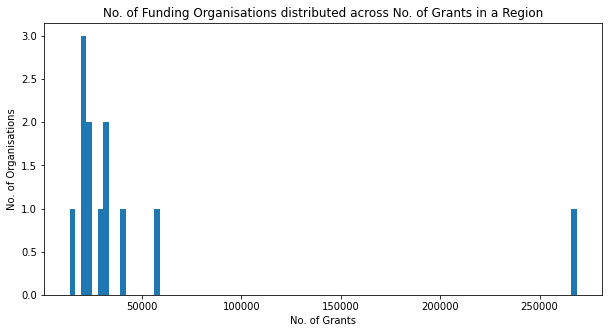

In [ ]:
degrees = [g.degree(n) for n in g.nodes()]

fig = plt.figure(figsize = (10, 5))

# plt.bar(g.nodes(), degrees, color ='maroon')
plt.hist(degrees,bins=90)

plt.xlabel("No. of Grants")
plt.ylabel("No. of Organisations")
plt.title("No. of Organisations distributed across No. of Grants in a Region")
plt.show()



#### Graph 2
- merged parallel edges - all grants from A to B merged into a single edge
- internal fundings not included

In [ ]:
# Building the Graph where nodes represent different regions
# MERGING PARALLEL EDGES
# TOTAL AMOUNT WILL BE THE SUM OF ALL GRANTS
# THE NUM_GRANTS ATTRIBUTE FOR EACH EDGE CONTAINS THE NUMBER OF GRANTS
g1 = nx.MultiDiGraph()
label_map = {}
for key,value in regionCodes.items():
  g1.add_node(value)
  label_map[value] = key

funds_map = {}
grant_map = {}
c=0
for i,row in df.iterrows():
  if(i%50000==0):
    print(i,end=" ")
  if(fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']!=0):
    receiver = row['Recipient Region']
    funder = fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']
    #avoid the cases of fund flows within the same region for now
    if(receiver==funder):
      c+=1
      continue
    
    if((funder,receiver) in funds_map):
      funds_map[(funder,receiver)] += row['Amount Awarded']
      grant_map[(funder,receiver)] += 1
    else:
      funds_map[(funder,receiver)] = row['Amount Awarded']
      grant_map[(funder,receiver)] = 1

for key in funds_map:
  g1.add_edge(key[0],key[1],amount=funds_map[key],num_grants=grant_map[key])
nx.set_node_attributes(g1, label_map, name="Label")
print("\nInternal Fundings :",c)
print("Nodes:",g1.number_of_nodes())
print("Edges:",g1.number_of_edges())

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 
Internal Fundings : 81416
Nodes: 12
Edges: 102


In [ ]:
nx.write_gexf(g1, "grants_merged.gexf",version='1.2draft')

#### Graph 3
- parallel edges merged
- internal fundings(self loops) included

In [ ]:
#In this graph internal fundings are also taken into consideration - self loops for nodes
g11 = nx.MultiDiGraph()
label_map = {}
for key,value in regionCodes.items():
  g11.add_node(value)
  label_map[value] = key

funds_map = {}
grant_map = {}
c=0
for i,row in df.iterrows():
  if(i%50000==0):
    print(i,end=" ")
  if(fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']!=0):
    receiver = row['Recipient Region']
    funder = fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']
    if((funder,receiver) in funds_map):
      funds_map[(funder,receiver)] += row['Amount Awarded']
      grant_map[(funder,receiver)] += 1
    else:
      funds_map[(funder,receiver)] = row['Amount Awarded']
      grant_map[(funder,receiver)] = 1

for key in funds_map:
  g11.add_edge(key[0],key[1],amount=funds_map[key],num_grants=grant_map[key])
nx.set_node_attributes(g11, label_map, name="Label")
print("\nInternal Fundings :",c)
print("Nodes:",g11.number_of_nodes())
print("Edges:",g11.number_of_edges())

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 
Internal Fundings : 0
Nodes: 12
Edges: 113


In [ ]:
nx.write_gexf(g11, "grants_merged_internal.gexf",version='1.2draft')

#### Graph 4 
- merged parallel edges
- internal fundings included
- all fundings from London region not included

In [ ]:
# Building the Graph where nodes represent different regions
# MERGING PARALLEL EDGES
# TOTAL AMOUNT WILL BE THE SUM OF ALL GRANTS
# THE NUM_GRANTS ATTRIBUTE FOR EACH EDGE CONTAINS THE NUMBER OF GRANTS
# NOT INCLUDING THE GRANTS CORRESPONDING TO LONDON  
g2 = nx.MultiDiGraph()
label_map = {}
for key,value in regionCodes.items():
  g2.add_node(value)
  label_map[value] = key

funds_map = {}
grant_map = {}
c=0
for i,row in df.iterrows():
  if(i%50000==0):
    print(i,end=" ")
  if(fundingOrg.at[row['Funding Org:Identifier'],'UKRegion'] not in [0,3]):
    receiver = row['Recipient Region']
    funder = fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']
    #avoid the cases of fund flows within the same region for now
    if(receiver==funder):
      c+=1
      continue
    
    if((funder,receiver) in funds_map):
      funds_map[(funder,receiver)] += row['Amount Awarded']
      grant_map[(funder,receiver)] += 1
    else:
      funds_map[(funder,receiver)] = row['Amount Awarded']
      grant_map[(funder,receiver)] = 1

for key in funds_map:
  g2.add_edge(key[0],key[1],amount=funds_map[key],num_grants=grant_map[key])
nx.set_node_attributes(g2, label_map, name="Label")
print("\nInternal Fundings :",c)
print("Nodes:",g2.number_of_nodes())
print("Edges:",g2.number_of_edges())

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 
Internal Fundings : 29900
Nodes: 12
Edges: 91


In [ ]:
nx.write_gexf(g2, "grants_merged_without_london.gexf",version='1.2draft')

## Focusing on Universities

In [139]:
df2 = df.dropna(subset=['Recipient Org:Name'])
uni_recip= df2[df2['Recipient Org:Name'].str.upper().str.contains('UNIVERSITY')]
print(uni_recip.shape)
uni_recip = uni_recip.reset_index(drop=True)
uni_recip.head()


(12628, 16)


,Identifier,Title,Description,Currency,Amount Applied For,Amount Awarded,Amount Disbursed,Recipient Org:Identifier,Recipient Org:Name,Recipient Org:Charity Number,Recipient Org:Company Number,Recipient Org:Postal Code,Recipient Region,Funding Org:Identifier,Funding Org:Name,Funding Org:Postal Code
0,360G-SE-2010013900LOTT_2011-10-04,Judo Excel Equipment,Funding under Sport England's Small Grants fun...,GBP,NaN,3400.0,NaN,360G-SE-University-of-Bath,University of Bath,NaN,NaN,BA14 0TN,9,GB-COH-RC000766,Sport England,NaN
1,360G-SE-2011000317LOTT_2011-10-05,Cambridge University Pythons American Football...,Funding under Sport England's Small Grants fun...,GBP,NaN,8044.0,NaN,360G-SE-Cambridge-University-Pythons-American-...,Cambridge University Pythons American Football...,NaN,NaN,CB23 7XX,2,GB-COH-RC000766,Sport England,NaN
2,360G-SE-2011011056EXCH_2011-11-04,University of Birmingham Lions American Footba...,Funding under Sport England's Sportsmatch fund...,GBP,NaN,5450.0,NaN,360G-SE-University-of-Birmingham-Lions-America...,University of Birmingham Lions American Footba...,NaN,NaN,B15 2TT,11,GB-COH-RC000766,Sport England,NaN
3,360G-SE-2011018552EXCH_2011-12-09,London FE Exchequer Pilot Project,Funding under Sport England's Core GIA funding...,GBP,NaN,100248.0,NaN,360G-SE-Brunel-University-(Pro-Active-West),Brunel University (Pro-Active West),NaN,NaN,UB8 3PH,3,GB-COH-RC000766,Sport England,NaN
4,360G-SE-2011019957EXCH_2011-12-16,PowerBase Wet Recovery and Athlete Lounge,Funding under Sport England's English Institut...,GBP,NaN,250000.0,NaN,360G-SE-Loughborough-University,Loughborough University,NaN,NaN,LE11 3TU,1,GB-COH-RC000766,Sport England,NaN


In [142]:
codeToRegions = {y:x for x,y in regionCodes.items()}
print(codeToRegions)

{1: 'East Midlands', 2: 'East of England', 3: 'London', 4: 'North East', 5: 'North West', 6: 'Northern Ireland', 7: 'Scotland', 8: 'South East Coast', 9: 'South West', 10: 'Wales', 11: 'West Midlands', 12: 'Yorkshire and the Humber'}


In [143]:
unc = Counter(uni_recip['Recipient Region'])
for i,j in unc.items():
  print(codeToRegions[i],j)

South West 1100
East of England 1506
West Midlands 1394
London 1578
East Midlands 863
North East 893
Yorkshire and the Humber 904
North West 1526
South East Coast 681
Scotland 1474
Wales 481
Northern Ireland 228


#### Graph 5
- only university recipients included
- in region fundings ignored

In [ ]:
# Flow of Funds towards Universities - in region funding ignored
g3 = nx.MultiDiGraph()
label_map = {}
for key,value in regionCodes.items():
  g1.add_node(value)
  label_map[value] = key

funds_map = {}
grant_map = {}
c=0
for i,row in uni_recip.iterrows():
  if(i%1000==0):
    print(i,end=" ")
  if(fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']!=0):
    receiver = row['Recipient Region']
    funder = fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']
    #avoid the cases of fund flows within the same region for now
    if(receiver==funder):
      c+=1
      continue
    
    if((funder,receiver) in funds_map):
      funds_map[(funder,receiver)] += row['Amount Awarded']
      grant_map[(funder,receiver)] += 1
    else:
      funds_map[(funder,receiver)] = row['Amount Awarded']
      grant_map[(funder,receiver)] = 1

for key in funds_map:
  g3.add_edge(key[0],key[1],amount=funds_map[key],num_grants=grant_map[key])
nx.set_node_attributes(g3, label_map, name="Label")
print("\nInternal Fundings :",c)
print("Nodes:",g3.number_of_nodes())
print("Edges:",g3.number_of_edges())

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 
Internal Fundings : 527
Nodes: 12
Edges: 31


In [ ]:
nx.write_gexf(g3, "grants_universities_merged_wit_london.gexf",version='1.2draft')

#### Graph 6
- university recipients
- in region fundings included

In [ ]:
#Flow of Funds towards Universities - including in region funding - self loops
g4 = nx.MultiDiGraph()
label_map = {}
for key,value in regionCodes.items():
  g4.add_node(value)
  label_map[value] = key

funds_map = {}
grant_map = {}
c=0
for i,row in uni_recip.iterrows():
  if(i%1000==0):
    print(i,end=" ")
  if(fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']!=0):
    receiver = row['Recipient Region']
    funder = fundingOrg.at[row['Funding Org:Identifier'],'UKRegion']
    #avoid the cases of fund flows within the same region for now
    if(receiver==funder):
      c+=row['Amount Awarded']
      
    
    if((funder,receiver) in funds_map):
      funds_map[(funder,receiver)] += row['Amount Awarded']
      grant_map[(funder,receiver)] += 1
    else:
      funds_map[(funder,receiver)] = row['Amount Awarded']
      grant_map[(funder,receiver)] = 1

for key in funds_map:
  g4.add_edge(key[0],key[1],amount=funds_map[key],num_grants=grant_map[key])
nx.set_node_attributes(g4, label_map, name="Label")
print("\nTotal Internal Fundings Amount:",c)
print("Nodes:",g4.number_of_nodes())
print("Edges:",g4.number_of_edges())

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 
Total Internal Fundings Amount: 138998186.34066728
Nodes: 12
Edges: 38


In [ ]:
nx.write_gexf(g4, "grants_universities_internal_with_london.gexf",version='1.2draft')

In [ ]:
# compare in region and out region fundings for university recipients
inregion = {}
outregion = {}
for key,val in funds_map.items():
  if(key[0]==key[1]):
    inregion[key[0]]=val
  elif(key[0] in outregion):
    outregion[key[0]]+=val
  else:
    outregion[key[0]]=val

inregion = {k:round(inregion[k],2) for k in sorted(inregion)}
outregion = {k:round(outregion[k],2) for k in sorted(outregion)}
print(inregion)
print(outregion)

{3: 133872113.62, 4: 4000270.22, 5: 31761.0, 6: 3151.0, 7: 729974.0, 8: 70000.0, 10: 290916.5}
{2: 60000.0, 3: 288822998.3, 4: 231619.0, 5: 1447776.93, 8: 95960.0, 9: 63606.0}


In [ ]:
# display region wise fundings - internal/external
uni_funds = {}
for i in range(1,13):
  internal = 0
  external = 0
  if(i in inregion):
    internal = inregion[i]
  if(i in outregion):
    external = outregion[i]
  uni_funds[codeToRegions[i]] = {"internal":internal,"external":external}

for r,v in uni_funds.items():
  print(r,":",v)


East Midlands : {'internal': 0, 'external': 0}
East of England : {'internal': 0, 'external': 60000.0}
London : {'internal': 133872113.62, 'external': 288822998.3}
North East : {'internal': 4000270.22, 'external': 231619.0}
North West : {'internal': 31761.0, 'external': 1447776.93}
Northern Ireland : {'internal': 3151.0, 'external': 0}
Scotland : {'internal': 729974.0, 'external': 0}
South East Coast : {'internal': 70000.0, 'external': 95960.0}
South West : {'internal': 0, 'external': 63606.0}
Wales : {'internal': 290916.5, 'external': 0}
West Midlands : {'internal': 0, 'external': 0}
Yorkshire and the Humber : {'internal': 0, 'external': 0}


In [ ]:
# create a dataframe for internal and external fundings for university recipients in a particular region
fundsdf = pd.DataFrame()
fundsdf['Region'] = uni_funds.keys()
fundsdf['Internal'] = [int(v['internal']) for k,v in uni_funds.items()]
fundsdf['External'] = [int(v['external']) for k,v in uni_funds.items()]
fundsdf

,Region,Internal,External
0,East Midlands,0,0
1,East of England,0,60000
2,London,133872113,288822998
3,North East,4000270,231619
4,North West,31761,1447776
5,Northern Ireland,3151,0
6,Scotland,729974,0
7,South East Coast,70000,95960
8,South West,0,63606
9,Wales,290916,0


## Degree Distribution

In [ ]:
#number of grants received by each organisation
receivers = {}
for i,row in data.iterrows():
  org = row['Recipient Org:Identifier']
  if org in receivers:
    receivers[org]+=1
  else:
    receivers[org]=1

In [ ]:
# {num of grants: num of orgs}
# how many organisations received exactly k grants?
orgCount = {}
for k,v in receivers.items():
  if v in orgCount:
    orgCount[v]+=1
  else:
    orgCount[v]=1

In [ ]:
print(sum(orgCount.values()))
print(len(receivers))

281145
281145


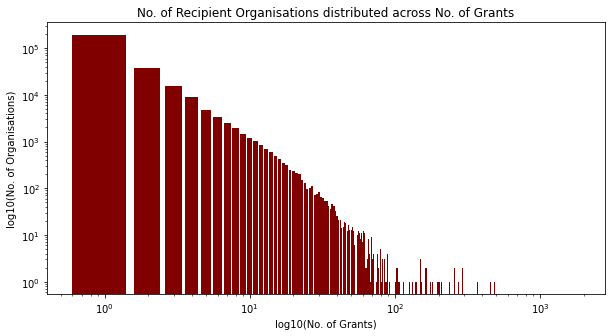

In [ ]:
# number of orgs distributed across number of grants
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))

plt.bar(orgCount.keys(), orgCount.values(), color ='maroon')

plt.loglog(basex=10,basey=10)
plt.xlabel("log10(No. of Grants)")
plt.ylabel("log10(No. of Organisations)")
plt.title("No. of Recipient Organisations distributed across No. of Grants")
plt.show()


In [ ]:
# find all grants with 0 or negative grant amount
c = 0
amount_array = set()
for i,row in data.iterrows():
  if(row['Currency']=="GBP" and row['Amount Awarded']<=0):
    # print(row['Identifier'],row['Recipient Org:Identifier'],row['Funding Org:Identifier'],row['Amount Awarded'])
    amount_array.add(row['Amount Awarded'])
    c+=1
print(c)
print(len(amount_array))
print(amount_array)

5059
1201
{0.0, -137215.0, -20480.0, -14336.0, -4090.91, -10233.0, -8185.0, -4085.72, -10228.0, -4085.0, -6130.5, -42993.0, -2032.02, -63471.0, -1970160.86, -16365.0, -8172.73, -26602.0, -16362.5, -22500.0, -59360.0, -24544.0, -6109.0, -2011.0, -28635.92, -2005.5, -16338.0, -2000.0, -1995.0, -10187.0, -14281.9, -45000.0, -79816.3, -610242.0, -8125.55, -42936.0, -22455.0, -26550.0, -112560.19, -26544.0, -40878.0, -18350.0, -1964.0, -1963.0, -30635.0, -1960.0, -49064.85, -65445.0, -16292.0, -1955.29, -1954.54, -6050.0, -4000.0, -8100.0, -8098.0, -3997.09, -28572.0, -10137.0, -8085.0, -26515.0, -90000.0, -102287.71, -10126.95, -1933.0, -49037.0, -1936.0, -38794.0, -1932.0, -10120.0, -69507.0, -6014.0, -16250.0, -190329.83, -102265.0, -1912.65, -1914.0, -8053.82, -10100.0, -6000.0, -67438.0, -8045.16, -1900.0, -5995.0, -121020265.0, -36712.0, -14184.0, -53091.36, -14176.0, -8029.0, -8021.13, -22355.0, -44879.0, -216911.11, -22346.0, -1862.0, -8006.0, -36672.05, -8000.0, -12090.91, -5945.45

In [ ]:
# total grant amount received by each organisation
# ignore grants with 0 or negative amount
receivers_amount = {}
for i,row in data.iterrows():
  org = row['Recipient Org:Identifier']
  if(row['Currency']!='GBP' or row['Amount Awarded']<=0):
    continue
  if org in receivers_amount:
    receivers_amount[org]+=row['Amount Awarded']
  else:
    receivers_amount[org]=row['Amount Awarded']

In [ ]:
# {grant amount: num of orgs}
# how many organisations received exactly k GBP in grant amount?
orgCountAmount = {}
for k,v in receivers_amount.items():
  if v in orgCountAmount:
    orgCountAmount[v]+=1
  else:
    orgCountAmount[v]=1

In [ ]:
print(sum(orgCountAmount.values()))
print(len(receivers_amount))

279349
279349


In [ ]:
print(min(orgCountAmount.keys()))
print(max(orgCountAmount.keys()))

0.67
4565232075.389999


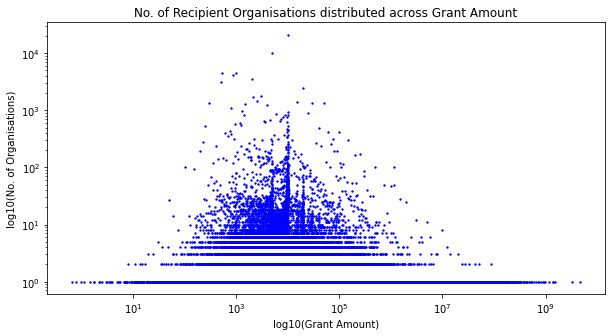

In [ ]:
# number of orgs distributed across amount of grant received
fig = plt.figure(figsize = (10, 5))

plt.scatter(orgCountAmount.keys(), orgCountAmount.values(), color ='blue',s=1.8)
plt.loglog(basex=10,basey=10)
plt.xlabel("log10(Grant Amount)")
plt.ylabel("log10(No. of Organisations)")
plt.title("No. of Recipient Organisations distributed across Grant Amount")
plt.show()

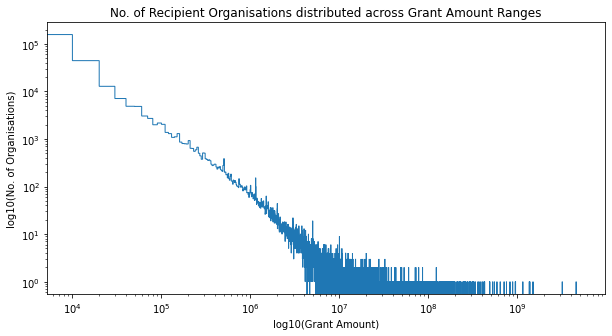

In [ ]:
fig = plt.figure(figsize = (10, 5))

bins1 = [0, 100, 500, 1000, 2000, 3000, 10000, 50000, 100000, 1000000, 5000000, 10000000, 100000000, 1000000000, 5000000000]
bins = [i for i in range(0,5000000000,10000)]

plt.hist(receivers_amount.values(),bins=bins, 
         histtype ='step')
plt.loglog(basex=10,basey=10)
plt.xlabel("log10(Grant Amount)")
plt.ylabel("log10(No. of Organisations)")
plt.title("No. of Recipient Organisations distributed across Grant Amount Ranges")
plt.show()

In [ ]:
#number of grants given by each organisation
givers = {}
for i,row in data.iterrows():
  org = row['Funding Org:Identifier']
  if org in givers:
    givers[org]+=1
  else:
    givers[org]=1

In [ ]:
# {num of grants: num of orgs}
# how many organisations gave exactly k grants?
orgCount1 = {}
for k,v in givers.items():
  if v in orgCount1:
    orgCount1[v]+=1
  else:
    orgCount1[v]=1

In [ ]:
print(sum(orgCount1.values()))
print(len(givers))

217
217


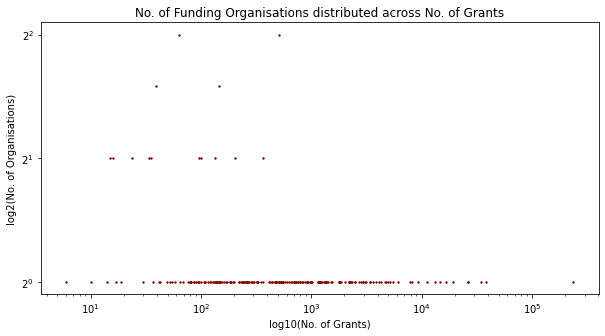

In [ ]:
#number of funding orgs distributed across number of grants
fig = plt.figure(figsize = (10, 5))

plt.scatter(orgCount1.keys(), orgCount1.values(), color ='maroon',s=1.8)

plt.loglog(basex=10,basey=2)
plt.xlabel("log10(No. of Grants)")
plt.ylabel("log2(No. of Organisations)")
plt.title("No. of Funding Organisations distributed across No. of Grants")
plt.show()
